<h2 align=center>Multi-Class Text Classification

### Context

To build text classificaton model using a dataset which contains corporations statements labelled as - `information`, `dialog`, or `action`.

### Understanding and loading the dataset

In [1]:
# load required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the dataset
data=pd.read_csv("corporate_statements.csv")

In [3]:
# see head of the dataset
data.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,category,category_confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2015-02-18T04:31:00,Information,1.0,NaN,436528000000000000,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2015-02-18T13:55:00,Information,1.0,NaN,386013000000000000,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2015-02-18T08:43:00,Information,1.0,NaN,379580000000000000,Barclays,Barclays publishes its prospectus for its �5.8...
3,662822311,False,finalized,3,2015-02-18T09:13:00,Information,1.0,NaN,367530000000000000,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2015-02-18T06:48:00,Information,1.0,NaN,360385000000000000,Barclays,Barclays announces that Irene McDermott Brown ...


In [4]:
# observe shape of the dataset
data.shape

(3118, 11)

In [5]:
# check distribution of categories
data["category"].value_counts()

Information    2129
Action          724
Dialogue        226
Exclude          39
Name: category, dtype: int64

In [6]:
# check distribution of the column - category_confidence
data["category_confidence"].value_counts()

1.0000    2430
0.6614      35
0.6643      33
0.6747      32
0.6775      29
          ... 
0.8547       1
0.6641       1
0.8578       1
0.9089       1
0.8245       1
Name: category_confidence, Length: 194, dtype: int64

In [7]:
# remove those observations where category_confidence < 1 and category = Exclude
data=data[(data["category_confidence"]==1) & (data["category"]!="Exclude")]

In [8]:
# extract features i.e the column - text and target i.e the column - category
features=data["text"]
target=data["category"]

### Text preprocessing

In [9]:
# import helpful libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download the stopwords and wordnet corpus
nltk.download('wordnet')
nltk.download('stopwords')

# extract the english stopwords and save it to a variable
stopword=stopwords.words('english')

# regular expression to identify urls in text
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# regular expression to identify non-ascii characters in text
non_ascii_regex = r'[^\x00-\x7F]+'

# write a function to tokenize text after performing preprocessing 
def tokenize(text):    
    text = re.sub(url_regex, 'urlplaceholder', text)
    text = re.sub(non_ascii_regex, ' ', text)
    tokens = word_tokenize(text)
    lemmetizer = WordNetLemmatizer()
    clean_tokens = [lemmetizer.lemmatize(word) for word in tokens if word not in stopword ]
    return clean_tokens

[nltk_data] Downloading package wordnet to /Users/dabasn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabasn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### EDA

<AxesSubplot:xlabel='category', ylabel='length'>

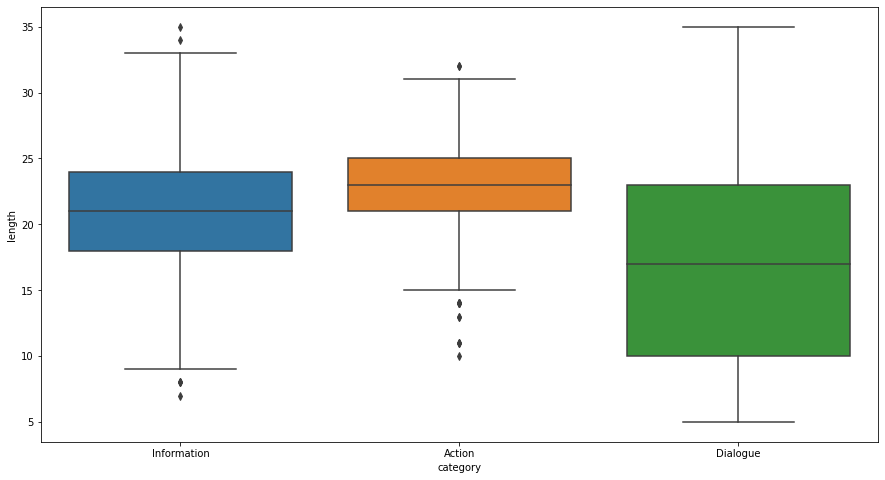

In [10]:
# checking length of each text in dataset
data['length'] = data['text'].apply(lambda x: len(word_tokenize(x)))

# use seaborn boxplot to visualize the pattern in length for each category
fig = plt.figure(figsize=(15,8))
sns.boxplot(x='category', y='length', data=data)

In [11]:
# chehcking total count of urls present in each text
data['url_count'] = data['text'].apply(lambda x: len(re.findall(url_regex,x)))

# use pandas crosstab to see the distibution of different url counts in each category
pd.crosstab(data['category'], data['url_count'], normalize=True)

url_count,0,1,2
category,,,
Action,0.014565,0.166042,0.009155
Dialogue,0.032876,0.018727,0.000000
Information,0.205576,0.533916,0.019143


### Creating custom transformers

In [12]:
# create a custom transformer LengthExtractor to extract length of each sentences
from sklearn.base import BaseEstimator, TransformerMixin

class LengthExtractor(BaseEstimator, TransformerMixin):
    def compute_length(self, text):
        sentence_list= word_tokenize(text)
        return(len(sentence_list))  
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return(pd.DataFrame(X_length))


In [13]:
# create a custom transformer UrlCounter to count number of urls in each sentences

class UrlCounter(BaseEstimator, TransformerMixin):
    def count_url(self, text):
        urls = re.findall(url_regex, text)
        return len(urls)
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        url_count=pd.Series(X).apply(self.count_url)
        return pd.DataFrame(url_count)
    

### Model Building using FeatureUnion

In [14]:
# import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# import Pipeline and FeatureUnion from sklearn
from sklearn.pipeline import Pipeline, FeatureUnion

# import CountVectorizer, TfidfTransformer from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [15]:
# create an instance of Pipeline class
pipeline = Pipeline([
        ('features', FeatureUnion([
            # pipeline to extract features using CountVectorizer and TfidfTransformer
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            # pipeline to extract lenght of each sentence as feature
            ('text_length', LengthExtractor()),
            # pipeline UrlCounter to extract url counts in each sentence as feature
            ('url_count', UrlCounter())
        ])),
        # use the predictor estimator RandomForestClassifier to train the model
        ('clf', RandomForestClassifier())
])

In [16]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) 

In [17]:
# use pipeline.fit method to train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7fc8464435f0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_length',
                                                 LengthExtractor()),
                                                ('url_count', UrlCounter())])),
                ('clf', RandomForestClassifier())])

### Model Evaluation

In [18]:
# use the method pipeline.predict on X_test data to predict the labels
y_pred = pipeline.predict(X_test)

<AxesSubplot:>

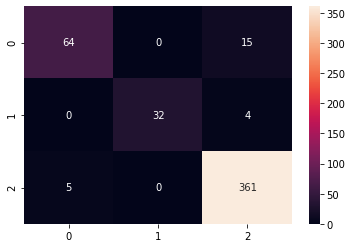

In [19]:
# create the confustion matrix, import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix

# count the number of labels
labels = np.unique(y_pred)

# use sns.heatmap on top of confusion_matrix to show the confusuin matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels=labels), annot=True, fmt='.0f')

In [20]:
# create the classification report, import classification_report from sklearn
from sklearn.metrics import classification_report

# apply the function classification_report on y_test, y_pred and print it
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.93      0.81      0.86        79
    Dialogue       1.00      0.89      0.94        36
 Information       0.95      0.99      0.97       366

    accuracy                           0.95       481
   macro avg       0.96      0.90      0.92       481
weighted avg       0.95      0.95      0.95       481

